# Classification by XGBRegressor

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)  
This work by Jing-Hau Huang and Jephian Lin is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Introduction to House Sales in King County, USA dataset

This dataset consists of Price of Houses in King County, Washington from sales between May 2014 and May 2015.<br><br>
The data is from Kaggle ([House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction))

Kaggle contains various data sets.  
Once you created a free account,  
you may have access to and download them.

Once you have downloaded the data set  
you may import it by  
`df = pd.read_csv('kc_house_data.csv')`.

In [2]:
data = pd.read_csv('kc_house_data.csv')
print(data.shape)
data.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


This is not a good example of data analysis  
since I cannot find the reliable descriptions about the features.  
(Let me know if you know the source/details of this data set.)

For the illustration purposes,  
we have a reasonable guess for the meanning of each column.

In [3]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

- **price**: Price of each home sold  
- bedrooms: numbers of bedrooms  
- bathrooms: number of bathrooms (containing non-integer entries?)  
- sqft_living: square footage of ???  
- sqft_lot: square footage of ???
- floors: numbers of floors (containing non-integer entries)  
- waterfront: whether it has waterfront or not
- view: nice view (0~4)  
- condition: the condition of the apartment (1~5)  
- grade: (1~13) 
- sqft_above: square footage of space above ground  
- sqft_basement: square footage of the basement
- yr_built: year built  
- yr_renovated: year last renovated  
- zipcode: zipcode (categorial)  
- lat: lattitude  
- long: longitude  
- sqft_living15: square footage of ???  
- sqft_lot15: square footage of ???

Use `np.unique([array[, return_counts=True)`  
to check the occurence of a values in a columns.

In [4]:
np.unique(data.lat, return_counts=True)

(array([47.1559, 47.1593, 47.1622, ..., 47.7774, 47.7775, 47.7776]),
 array([1, 1, 1, ..., 1, 3, 3]))

Replace `yr_built` by the house age by the time it was sold.  
Replace `yr_renovated` by the age after renovated by the time it was sold.

In [5]:
data = pd.read_csv('kc_house_data.csv')
data['yr_built'] = data['date'].str[:4].astype(int) - data['yr_built']
mask = data['yr_renovated'] > 0
data.loc[mask, 'yr_renovated'] = data.loc[mask, 'date'].str[:4].astype(int) - data.loc[mask, 'yr_renovated']

In [6]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,59,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,63,23,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,82,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,49,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,28,0,98074,47.6168,-122.045,1800,7503


Take `X` as all the columns other than `id`, `date`, and `price`.  
Take `y` as the column of `price`.

In [7]:
X = data.iloc[:, 3:]
y = data.iloc[:, 2]

Split the data.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
print(X_train.shape)
print(X_test.shape)

(16209, 18)
(5404, 18)


## XGBRegressor model

See [Introduction-to-XGBClassifier](https://github.com/jephianlin/ModularPython/blob/master/Introduction-to-XGBClassifier.ipynb) for  
more information about XGBoost.

In [11]:
import xgboost as xgb

In [12]:
model1 = xgb.XGBRegressor()
model1.fit(X_train, y_train)
y_model1 = model1.predict(X_test)

Use `mean_squared_error` to evaluate the performance.

In [13]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_model1) / y_test.shape[0]

2581938.408741029

#### Hyperparameters of XGBoost
`colsample_bytree`: float; Subsample ratio of columns when constructing each tree.  
`learning_rate`: float;  Boosting learning rate (xgb's "eta" $\eta$)  
`max_depth`: int;  Maximum tree depth for base learners.  

See a list [here](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [14]:
model2 = xgb.XGBRegressor(colsample_bytree=0.6, learning_rate=0.3, max_depth=5)
model2.fit(X_train, y_train)
y_model2 = model2.predict(X_test)

mean_squared_error(y_test, y_model2) / y_test.shape[0]

2620031.528547216

## Cross validation and hyperparameter

In [15]:
from sklearn.model_selection import cross_val_score

The default score for regression is R2.

In [16]:
print(cross_val_score(model1, X, y, cv=3))
print(cross_val_score(model2, X, y, cv=3))

[0.87884148 0.87869525 0.87208372]
[0.87876011 0.87779849 0.87089951]


apply grid search to find good hyperparameter

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
model = xgb.XGBRegressor()
choices = {'colsample_bytree': [0.5, 1], 
           'learning_rate': [0.1, 0.3, 0.5],
           'max_depth': [3, 7]
          }


In [19]:
grid = GridSearchCV(model, cv=3, 
                    param_grid=choices)

In [20]:
grid.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

In [21]:
print(grid.best_score_)
print(grid.best_params_)

0.884808470019013
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7}


## Dig into the model

One of the nice feature of XGBoost  
is that it allows you  
to know the importance of each feature.  

Use `xgb.plot_importance([model_name])`  
to visualize the feature importances.

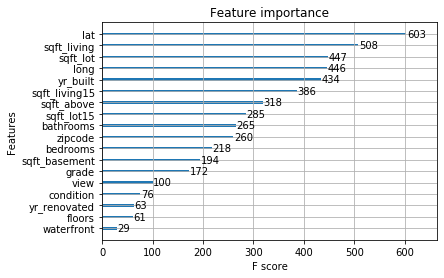

In [22]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgb.plot_importance(model)

Set the `figsize` to make it bigger if necessary.

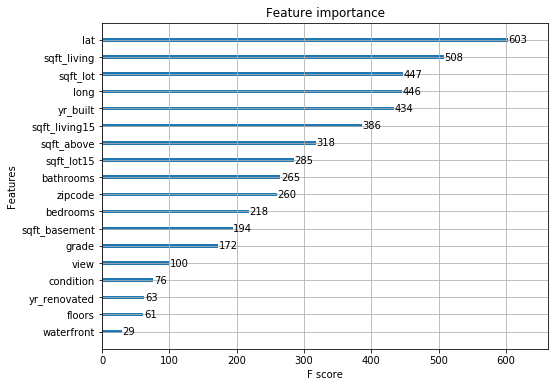

In [23]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
xgb.plot_importance(model, ax=ax)

To understand the model  
and the meaning of the feature importance,  
use `model.get_booster().trees_to_dataframe()`  
to show  the information of the trees and their nodes.

In [24]:
df = model.get_booster().trees_to_dataframe()
df.head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,grade,9.00000,0-1,0-2,0-1,7.157654e+14,16209.0
1,0,1,0-1,lat,47.53455,0-3,0-4,0-3,1.410489e+14,12996.0
2,0,2,0-2,sqft_living,4185.00000,0-5,0-6,0-5,2.465915e+14,3213.0
3,0,3,0-3,sqft_living,2026.00000,0-7,0-8,0-7,1.892732e+13,5522.0
4,0,4,0-4,sqft_living,2035.00000,0-9,0-10,0-9,5.997278e+13,7474.0


Use `model.get_booster().get_score()`  
to see the importance of each feature.

In [25]:
bster = model.get_booster()
bster.get_score()

{'grade': 172,
 'lat': 603,
 'sqft_living': 508,
 'view': 100,
 'long': 446,
 'sqft_lot15': 285,
 'sqft_living15': 386,
 'waterfront': 29,
 'yr_built': 434,
 'sqft_above': 318,
 'sqft_lot': 447,
 'zipcode': 260,
 'bathrooms': 265,
 'condition': 76,
 'sqft_basement': 194,
 'yr_renovated': 63,
 'bedrooms': 218,
 'floors': 61}

There are five `importance_type`:
* `weight`: the number of times a feature is used to split the data across all trees.
* `gain`: the average gain across all splits the feature is used in.
* `cover`: the average coverage across all splits the feature is used in.
* `total_gain`: the total gain across all splits the feature is used in.
* `total_cover`: the total coverage across all splits the feature is used in.

In [26]:
bster.get_score?

For example, if `importance_type='gain'`  
then the importance of a feature  
is set to the sum of all gains  
of nodes spliting the given feature.

In [27]:
bster.get_score(importance_type='total_gain')

{'grade': 1529191402057622.0,
 'lat': 677098700049216.0,
 'sqft_living': 983087655522052.0,
 'view': 64833280884576.0,
 'long': 244396996047466.0,
 'sqft_lot15': 29345285547748.0,
 'sqft_living15': 121364134289318.0,
 'waterfront': 119276852016864.0,
 'yr_built': 149467302775124.0,
 'sqft_above': 56584802449976.0,
 'sqft_lot': 37447289096930.0,
 'zipcode': 63893605798902.0,
 'bathrooms': 23997500979763.625,
 'condition': 8434646666420.0,
 'sqft_basement': 15223422354430.0,
 'yr_renovated': 4698481856680.0,
 'bedrooms': 5768105985975.6875,
 'floors': 2708521046866.0}

In [28]:
gains = {f: df.Gain[ df.Feature == f ].sum() for f in bster.feature_names}
gains

{'bedrooms': 5768105985975.6875,
 'bathrooms': 23997500979763.625,
 'sqft_living': 983087655522052.0,
 'sqft_lot': 37447289096930.0,
 'floors': 2708521046866.0,
 'waterfront': 119276852016864.0,
 'view': 64833280884576.0,
 'condition': 8434646666420.0,
 'grade': 1529191402057622.0,
 'sqft_above': 56584802449976.0,
 'sqft_basement': 15223422354430.0,
 'yr_built': 149467302775124.0,
 'yr_renovated': 4698481856680.0,
 'zipcode': 63893605798902.0,
 'lat': 677098700049216.0,
 'long': 244396996047466.0,
 'sqft_living15': 121364134289318.0,
 'sqft_lot15': 29345285547748.0}